# Sentiment Classification of Movie Reviews (Hugging Face)

### Notebook Overview

An alternative approach to sentiment classification using the IMDB dataset loaded via Hugging Face. This notebook explores a different workflow to the TF-IDF approach in [01-sentiment-classification](01-sentiment-classification.ipynb), including POS-aware lemmatization, custom stopword removal based on word frequency analysis, and exploratory visualisations.

### 1 - Importing Libraries

In [1]:
# Core Libraries
import re
import numpy as np
import pandas as pd
from collections import Counter

# Data
from datasets import load_dataset

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

/Users/annie/Repos/nlp-movie-sentiment/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /Users/annie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/annie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/annie/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/annie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/annie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/annie/nltk_data...

### 2 - Load & Explore Dataset

The IMDB dataset contains 50,000 movie reviews (25,000 train, 25,000 test). A sample of 500 reviews is used for faster iteration.

In [2]:
# Load IMDB dataset from Hugging Face
dataset = load_dataset('imdb')

# Sample 500 reviews for faster processing
sample_size = 500
train_sample = dataset['train'].shuffle(seed=42).select(range(sample_size))

# Convert to DataFrame and rename columns
df = pd.DataFrame(train_sample)
df.columns = ['review', 'sentiment']
df.head()

,review,sentiment
0,There is no relation at all between Fortier an...,1
1,This movie is a great. The plot is very true t...,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0
3,In the process of trying to establish the audi...,1
4,"Yeh, I know -- you're quivering with excitemen...",0


In [3]:
# Check for missing values and class balance
print(df.isnull().sum())
print()
print(df['sentiment'].value_counts(normalize=True))

review       0
sentiment    0
dtype: int64

sentiment
0    0.508
1    0.492
Name: proportion, dtype: float64


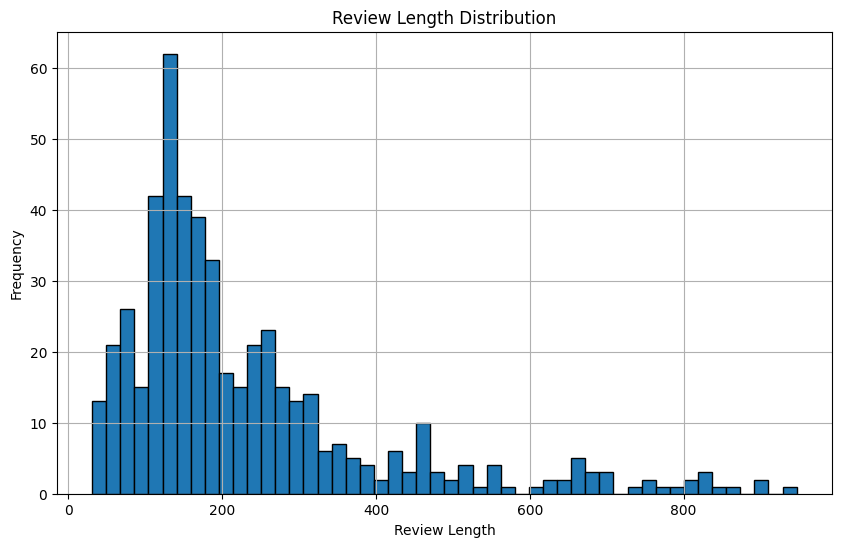

In [4]:
# Review length distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
df['review_length'].hist(bins=50, edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Review Length Distribution')
plt.show()

### 3 - Text Preprocessing

Text is cleaned by lowercasing, removing numbers and punctuation, then tokenised with POS-aware lemmatization and stopword removal.

In [5]:
def clean_text(text):
    # Lowercase, remove numbers and punctuation
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_text)
df.head()

,review,sentiment,review_length,clean_review
0,There is no relation at all between Fortier an...,1,125,there is no relation at all between fortier an...
1,This movie is a great. The plot is very true t...,1,131,this movie is a great the plot is very true to...
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,177,george p cosmatos rambo first blood part ii is...
3,In the process of trying to establish the audi...,1,119,in the process of trying to establish the audi...
4,"Yeh, I know -- you're quivering with excitemen...",0,636,yeh i know youre quivering with excitement we...


In [6]:
def get_wordnet_pos(tag):
    # Map POS tag to WordNet POS for better lemmatization
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(review):
    # Tokenize, POS-tag, lemmatize, and remove stopwords
    words = word_tokenize(review)
    tagged_tokens = pos_tag(words)
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    words = [word for word in words if word not in stop_words and len(word) > 1]
    return words

# Apply tokenization
df['clean_review'] = df['clean_review'].apply(tokenize_and_remove_stopwords)
df.head()

,review,sentiment,review_length,clean_review
0,There is no relation at all between Fortier an...,1,125,"[relation, fortier, profiler, fact, police, se..."
1,This movie is a great. The plot is very true t...,1,131,"[movie, great, plot, true, book, classic, writ..."
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,177,"[george, cosmatos, rambo, first, blood, part, ..."
3,In the process of trying to establish the audi...,1,119,"[process, try, establish, audience, empathy, j..."
4,"Yeh, I know -- you're quivering with excitemen...",0,636,"[yeh, know, youre, quiver, excitement, well, s..."


### 4 - Word Frequency Analysis

Visualise the most common words in positive and negative reviews to identify shared high-frequency words that can be removed as custom stopwords.

In [7]:
# Split by sentiment and count word frequencies
positive_reviews = df[df['sentiment'] == 1]
negative_reviews = df[df['sentiment'] == 0]

positive_tokens = [word for review in positive_reviews['clean_review'] for word in review]
negative_tokens = [word for review in negative_reviews['clean_review'] for word in review]

positive_top_words = Counter(positive_tokens).most_common(15)
negative_top_words = Counter(negative_tokens).most_common(15)

positive_df = pd.DataFrame(positive_top_words, columns=['Word', 'Count'])
negative_df = pd.DataFrame(negative_top_words, columns=['Word', 'Count'])

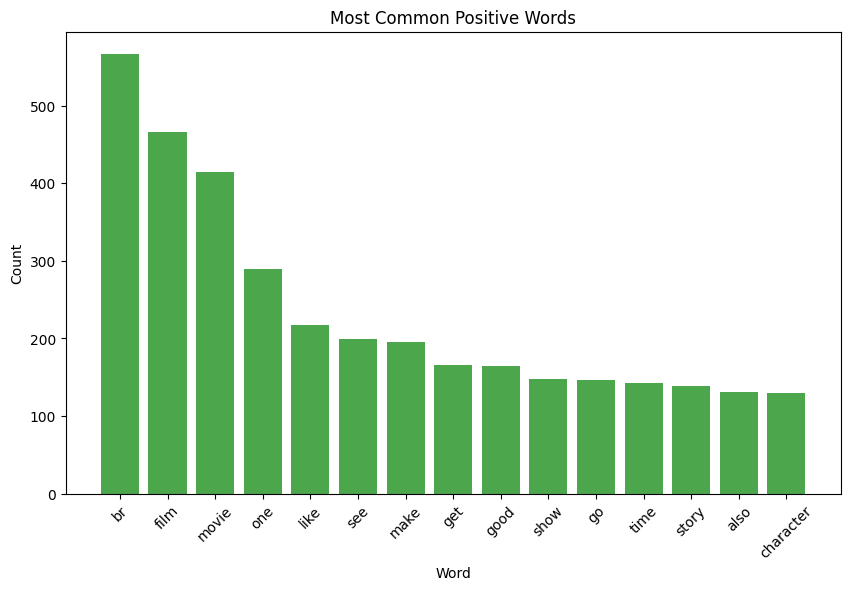

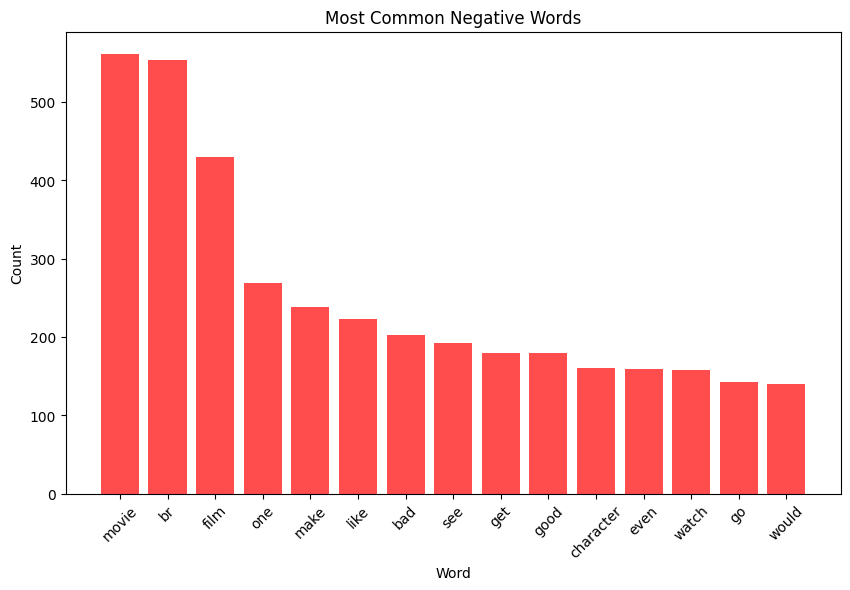

In [8]:
# Plot most common words for each sentiment
plt.figure(figsize=(10, 6))
plt.bar(positive_df['Word'], positive_df['Count'], color='green', alpha=0.7)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Most Common Positive Words')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(negative_df['Word'], negative_df['Count'], color='red', alpha=0.7)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Most Common Negative Words')
plt.show()

### 5 - Remove Custom Stopwords

Words appearing in both the top positive and top negative lists are unlikely to carry sentiment signal. Remove them as custom stopwords.

In [9]:
# Identify and remove words common to both sentiment classes
custom_stop_words = set(positive_df['Word']).intersection(set(negative_df['Word']))
print(f"Custom stopwords: {custom_stop_words}")

df['clean_review'] = df['clean_review'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stop_words]
)

# Join tokens back into strings for vectorization
df['clean_review'] = df['clean_review'].apply(lambda x: ' '.join(x))
df.head()

Custom stopwords: {'film', 'one', 'br', 'like', 'make', 'go', 'get', 'good', 'see', 'movie', 'character'}


,review,sentiment,review_length,clean_review
0,There is no relation at all between Fortier an...,1,125,relation fortier profiler fact police series v...
1,This movie is a great. The plot is very true t...,1,131,great plot true book classic write mark twain ...
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,177,george cosmatos rambo first blood part ii pure...
3,In the process of trying to establish the audi...,1,119,process try establish audience empathy jake ro...
4,"Yeh, I know -- you're quivering with excitemen...",0,636,yeh know youre quiver excitement well secret l...


### 6 - Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['sentiment'], test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Training set: 400
Test set: 100


### 7 - TF-IDF Vectorization

In [11]:
# Vectorize with TF-IDF, limiting to top 5000 features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Training shape: {X_train_vec.shape}")
print(f"Test shape: {X_test_vec.shape}")

Training shape: (400, 5000)
Test shape: (100, 5000)


### 8 - Logistic Regression Baseline

Train a Logistic Regression model and evaluate with a confusion matrix.

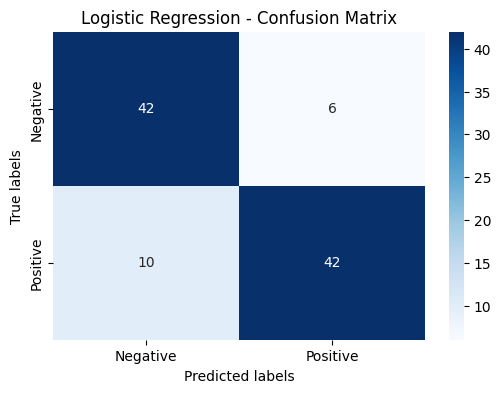

In [12]:
# Train Logistic Regression
mod = LogisticRegression()
mod.fit(X_train_vec, y_train)

# Predict and build confusion matrix
y_pred = mod.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

### 9 - Pipeline & Hyperparameter Tuning

Use an sklearn Pipeline to combine vectorization and classification into a single workflow, then apply GridSearchCV to find the best parameters.

In [13]:
# Define pipeline
pipe = Pipeline(steps=[('vec', TfidfVectorizer()), ('mod', LogisticRegression())])

# Define parameter grid
param_grid = {
    'vec__max_features': [1000, 5000, 10000],
    'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'mod__C': [0.01, 0.1, 1, 10]
}

# Run grid search with 3-fold cross-validation
grid = GridSearchCV(estimator=pipe, param_grid=param_grid,
                    scoring='accuracy', cv=3, verbose=3)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(1, 1);, score=0.515 total time=   0.0s
[CV 2/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(1, 1);, score=0.511 total time=   0.0s
[CV 3/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(1, 1);, score=0.519 total time=   0.0s
[CV 1/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(1, 2);, score=0.515 total time=   0.0s
[CV 2/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(1, 2);, score=0.511 total time=   0.0s
[CV 3/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(1, 2);, score=0.519 total time=   0.0s
[CV 1/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(2, 2);, score=0.515 total time=   0.0s
[CV 2/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(2, 2);, score=0.511 total time=   0.0s
[CV 3/3] END mod__C=0.01, vec__max_features=1000, vec__ngram_range=(2, 2);, score=

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'mod__C': [0.01, 0.1, ...], 'vec__max_features': [1000, 5000, ...], 'vec__ngram_range': [(1, ...), (1, ...), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter

Best parameters: {'mod__C': 1, 'vec__max_features': 1000, 'vec__ngram_range': (1, 1)}


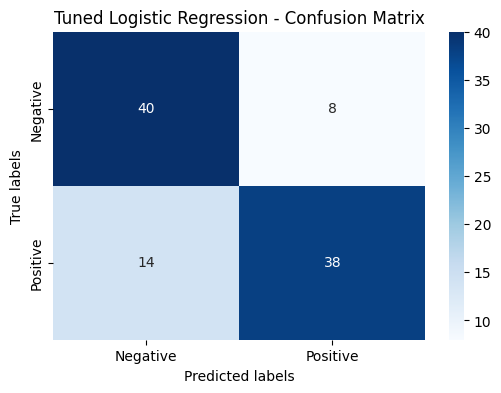

In [14]:
# Best parameters
print(f"Best parameters: {grid.best_params_}")

# Evaluate best model on test set
y_pred = grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned Logistic Regression - Confusion Matrix')
plt.show()

### 10 - XGBoost Classifier

Compare performance using XGBoost as an alternative classifier.

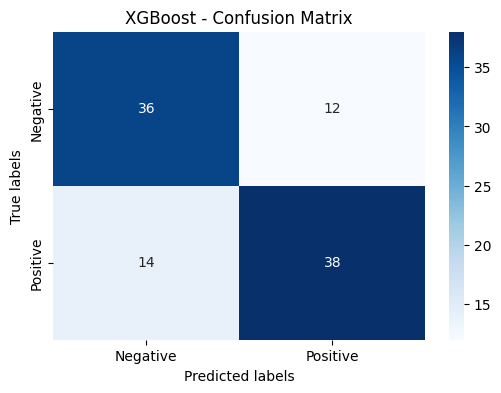

In [15]:
# Train XGBoost via pipeline
xgb_pipe = Pipeline(steps=[('vec', TfidfVectorizer()), ('mod', XGBClassifier())])
xgb_pipe.fit(X_train, y_train)

# Predict and build confusion matrix
y_pred = xgb_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('XGBoost - Confusion Matrix')
plt.show()